In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('MyUberDrives.csv')

df.head(5)

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [3]:
# 一番下の行は使わないので削除
df = df.drop(1155)

In [4]:
df['START_DATE*'] = pd.to_datetime(df['START_DATE*'])

In [5]:
def time_hour_split(x):
    t = str(x['START_DATE*'])
    t = t.split()
    ret = t[1].split(':')
    return ret[0]

def date_month_split(x):
    t = str(x['START_DATE*'])
    t = t.split()
    ret = t[0].split('-')
    return ret[1]

In [6]:
# START_DATE* から日付の時刻と月を分けて新たな属性として追加する
df['START_HOUR_TIME'] = df.apply(lambda x: time_hour_split(x), axis=1) 
df['MONTH'] = df.apply(lambda x: date_month_split(x), axis=1) 

In [7]:
# 日付から曜日を取得
df['weekday'] = df['START_DATE*'].dt.dayofweek

In [8]:
df['PURPOSE*'] = df[['PURPOSE*']].fillna('Unknown')

In [9]:
df['PURPOSE*'].value_counts()

Unknown            502
Meeting            187
Meal/Entertain     160
Errand/Supplies    128
Customer Visit     101
Temporary Site      50
Between Offices     18
Moving               4
Airport/Travel       3
Commute              1
Charity ($)          1
Name: PURPOSE*, dtype: int64

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['CATEGORY*'] = df[['CATEGORY*']].apply(le.fit_transform)
df['PURPOSE*'] = df[['PURPOSE*']].apply(le.fit_transform)
df['START*'] = df[['START*']].apply(le.fit_transform)
df['STOP*'] = df[['STOP*']].apply(le.fit_transform)

In [11]:
df['START_HOUR_TIME'] = df[['START_HOUR_TIME']].astype(np.float32)
df['MONTH'] = df[['MONTH']].astype(np.float32)

In [12]:
df.head(10)

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*,START_HOUR_TIME,MONTH,weekday
0,2016-01-01 21:11:00,1/1/2016 21:17,0,52,49,5.1,6,21.0,1.0,4
1,2016-01-02 01:25:00,1/2/2016 1:37,0,52,49,5.0,10,1.0,1.0,5
2,2016-01-02 20:25:00,1/2/2016 20:38,0,52,49,4.8,5,20.0,1.0,5
3,2016-01-05 17:31:00,1/5/2016 17:45,0,52,49,4.7,7,17.0,1.0,1
4,2016-01-06 14:42:00,1/6/2016 15:49,0,52,181,63.7,4,14.0,1.0,2
5,2016-01-06 17:15:00,1/6/2016 17:19,0,171,181,4.3,6,17.0,1.0,2
6,2016-01-06 17:30:00,1/6/2016 17:35,0,171,122,7.1,7,17.0,1.0,2
7,2016-01-07 13:27:00,1/7/2016 13:33,0,17,20,0.8,7,13.0,1.0,3
8,2016-01-10 08:05:00,1/10/2016 8:25,0,17,107,8.3,7,8.0,1.0,6
9,2016-01-10 12:17:00,1/10/2016 12:44,0,70,110,16.5,4,12.0,1.0,6


In [13]:
df['CATEGORY*'].value_counts()

0    1078
1      77
Name: CATEGORY*, dtype: int64

Business が 0, Personal が 1

In [14]:
df['PURPOSE*'].value_counts()

10    502
7     187
6     160
5     128
4     101
9      50
1      18
8       4
0       3
3       1
2       1
Name: PURPOSE*, dtype: int64

In [15]:
for key in df.keys():
    print(key, len(df.groupby(key).size()))

START_DATE* 1154
END_DATE* 1154
CATEGORY* 2
START* 177
STOP* 188
MILES* 256
PURPOSE* 11
START_HOUR_TIME 23
MONTH 12
weekday 7


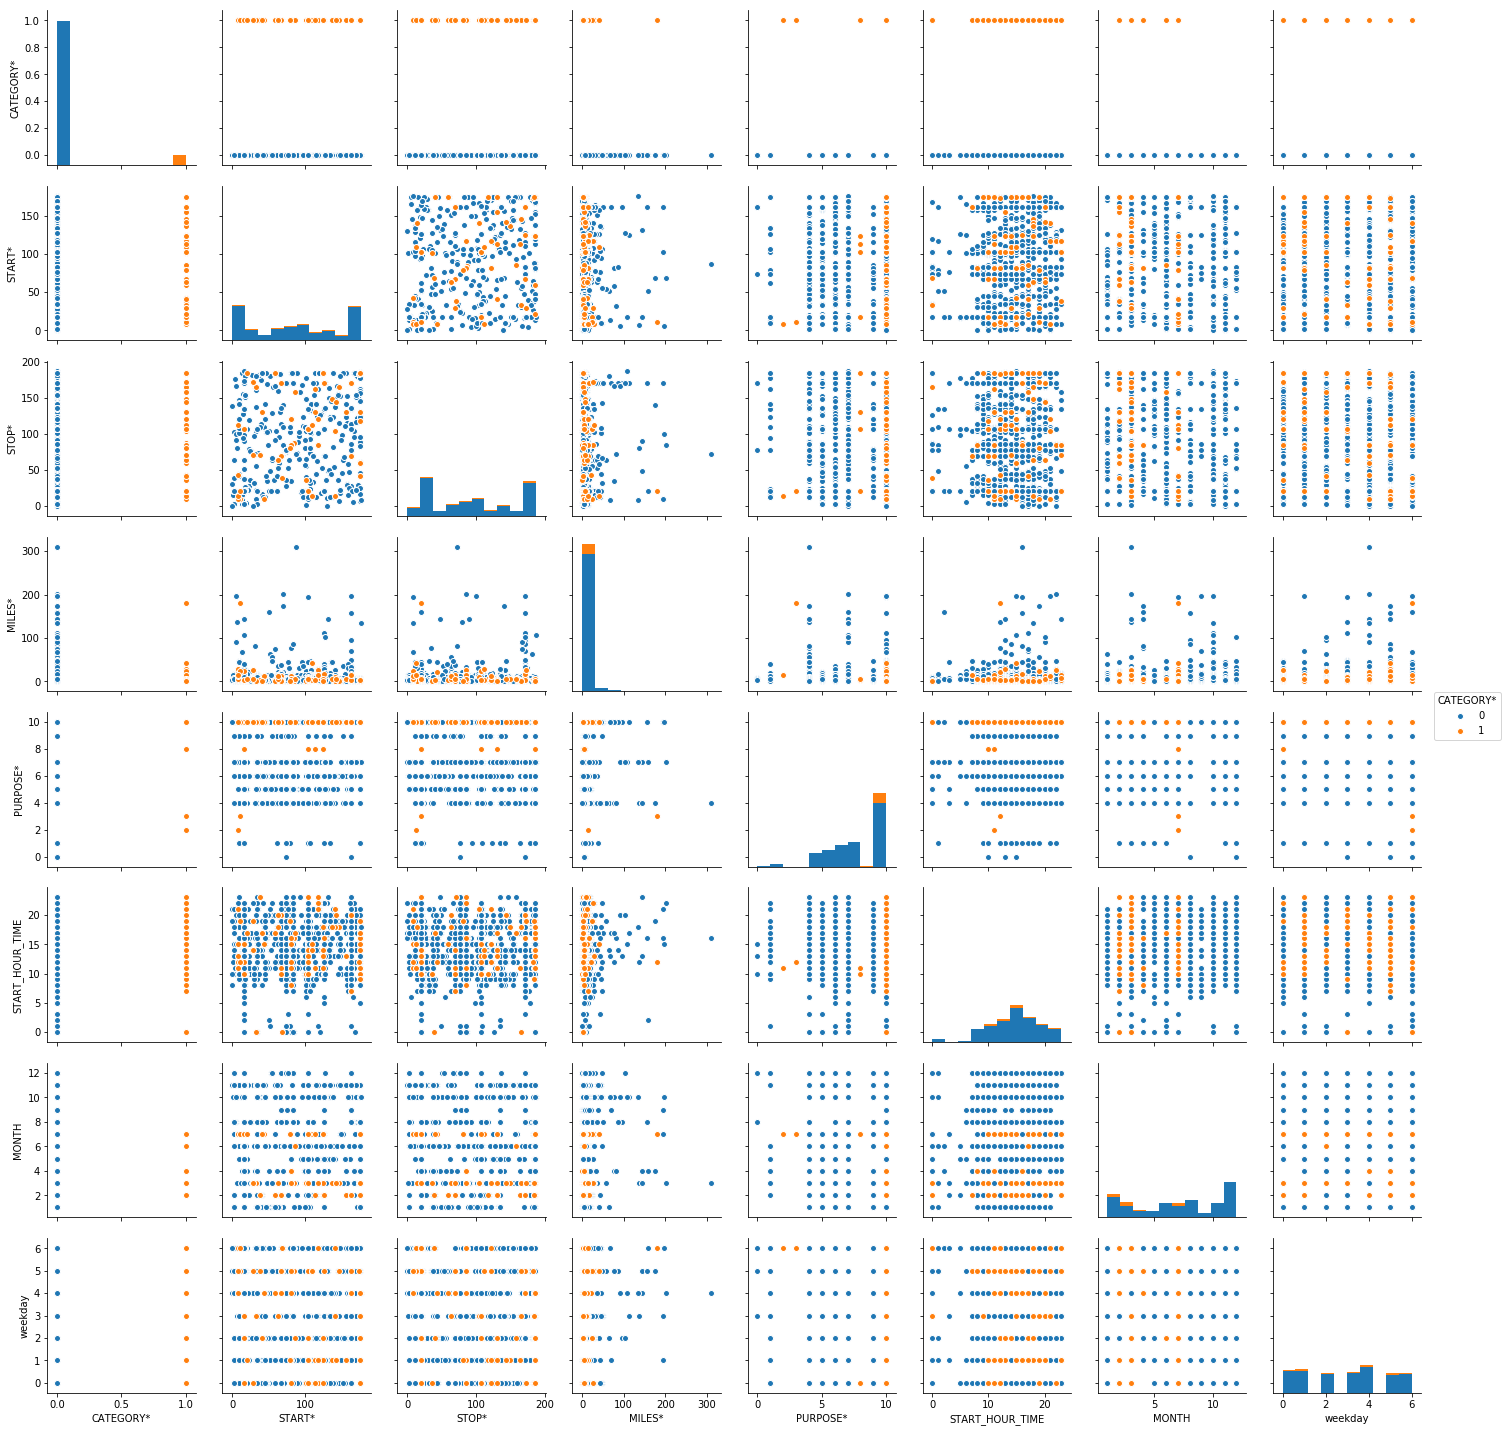

In [16]:
sns.pairplot(df[['CATEGORY*','START*', 'STOP*', 'MILES*','PURPOSE*', 'START_HOUR_TIME', 'MONTH','weekday']], hue='CATEGORY*')
plt.show()

MILES,PURPOSE, START_HOUR_TIME, MONTH, weekday の ５つの属性からエントロピーを求めて使う特徴を決めることにする。       

In [17]:
# 親のエントロピーを求める。
category_len = len(df.groupby('CATEGORY*').size())
parent_prob = []
parent_entropy = 0
for i in range(0,category_len):
    p = len(df[df['CATEGORY*']==i]) / len(df)
    parent_prob.append(p)

for i in parent_prob:
    parent_entropy += i*np.log2(i)
parent_entropy = (-1)*parent_entropy
print(parent_entropy)

0.353359335021


In [18]:
# PURPOSEのエントロピーを計算する
purpose_len = len(df.groupby('PURPOSE*').size())
purpose_entropy = []
for i in range(0,purpose_len):
    t = df[df['PURPOSE*']==i]
    if not len(t) == 0:
        p0 = (len(t[t['CATEGORY*']==0])+1) / len(t)
        p1 = (len(t[t['CATEGORY*']==1])+1)/ len(t)
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        purpose_entropy.append(entropy)
        
# PURPOSEでのIGを求める
e=0
for i in range(0,purpose_len):
    e += (len(df[df['PURPOSE*']==i])/len(df))*purpose_entropy[i]
    
purpose_IG = parent_entropy - e

In [19]:
# START_HOUR_TIMEのエントロピーを計算する
START_HOUR_TIME_len = len(df.groupby('START_HOUR_TIME').size())
START_HOUR_TIME_entropy = []
for i in range(0,START_HOUR_TIME_len):
    t = df[df['START_HOUR_TIME']==int(i)]
    if not len(t) == 0:
        p0 = (len(t[t['CATEGORY*']==0])+1) / len(t)
        p1 = (len(t[t['CATEGORY*']==1])+1)/ len(t)
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        START_HOUR_TIME_entropy.append(entropy)
    else:
        p0 = (len(t[t['CATEGORY*']==0])+1) / 1
        p1 = (len(t[t['CATEGORY*']==1])+1)/ 1
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        START_HOUR_TIME_entropy.append(entropy)
# START_HOUR_TIMEでのIGを求める
e=0
for i in range(0,START_HOUR_TIME_len):
    e += (len(df[df['START_HOUR_TIME']==i])/len(df))*START_HOUR_TIME_entropy[i]
    
START_HOUR_TIME_IG = parent_entropy - e

In [20]:
# weekdayのエントロピーを計算する
weekday_len = len(df.groupby('weekday').size())
weekday_entropy = []
for i in range(0,weekday_len):
    t = df[df['weekday']==int(i)]
    if not len(t) == 0:
        p0 = (len(t[t['CATEGORY*']==0])+1) / len(t)
        p1 = (len(t[t['CATEGORY*']==1])+1)/ len(t)
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        weekday_entropy.append(entropy)
    else:
        p0 = (len(t[t['CATEGORY*']==0])+1) / 1
        p1 = (len(t[t['CATEGORY*']==1])+1)/ 1
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        weekday_entropy.append(entropy)
# weekdayでのIGを求める
e=0
for i in range(0,weekday_len):
    e += (len(df[df['weekday']==i])/len(df))*weekday_entropy[i]
    
weekday_IG = parent_entropy - e

In [21]:
# MONTHのエントロピーを計算する
MONTH_len = len(df.groupby('MONTH').size())
MONTH_entropy = []
for i in range(0,MONTH_len):
    t = df[df['MONTH']==int(i)]
    if not len(t) == 0:
        p0 = (len(t[t['CATEGORY*']==0])+1) / len(t)
        p1 = (len(t[t['CATEGORY*']==1])+1)/ len(t)
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        MONTH_entropy.append(entropy)
    else:
        p0 = (len(t[t['CATEGORY*']==0])+1) / 1
        p1 = (len(t[t['CATEGORY*']==1])+1)/ 1
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        MONTH_entropy.append(entropy)
# MONTHでのIGを求める
e=0
for i in range(0,MONTH_len):
    e += (len(df[df['MONTH']==i])/len(df))*MONTH_entropy[i]
    
MONTH_IG = parent_entropy - e

In [22]:
# MILES*のエントロピーを計算する
MILES_len = len(df.groupby('MILES*').size())
MILES_entropy = []
for i in range(0,MILES_len):
    t = df[df['MILES*']==int(i)]
    if not len(t) == 0:
        p0 = (len(t[t['CATEGORY*']==0])+1) / len(t)
        p1 = (len(t[t['CATEGORY*']==1])+1)/ len(t)
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        MILES_entropy.append(entropy)
    else:
        p0 = (len(t[t['CATEGORY*']==0])+1) / 1
        p1 = (len(t[t['CATEGORY*']==1])+1)/ 1
        entropy = -(p0*np.log2(p0) + p1*(np.log2(p1)))
        MILES_entropy.append(entropy)
# MILES*でのIGを求める
e=0
for i in range(0,MILES_len):
    e += (len(df[df['MILES*']==i])/len(df))*MILES_entropy[i]
    
MILES_IG = parent_entropy - e

In [23]:
print("purpose_IG : "+str(purpose_IG))
print("START_HOUR_TIME_IG : "+str(START_HOUR_TIME_IG))
print("weekday_IG : "+str(weekday_IG))
print("MONTH_IG : "+str(MONTH_IG))
print("MILE_IG : "+str(MILES_IG))

purpose_IG : 0.0752320678574
START_HOUR_TIME_IG : 0.00966043489261
weekday_IG : -0.000666999485258
MONTH_IG : 0.084733855268
MILE_IG : 0.338894875856


weekdayは使わないことにする。      

In [24]:
train_df = pd.DataFrame()
train_df['CATEGORY*'] = df[['CATEGORY*']]
train_df['MILES*'] = df[['MILES*']]
train_df['PURPOSE*'] = df[['PURPOSE*']]
train_df['MONTH'] = df[['MONTH']]
train_df['START_HOUR_TIME'] = df[['START_HOUR_TIME']]
train_df.head(5)

,CATEGORY*,MILES*,PURPOSE*,MONTH,START_HOUR_TIME
0,0,5.1,6,1.0,21.0
1,0,5.0,10,1.0,1.0
2,0,4.8,5,1.0,20.0
3,0,4.7,7,1.0,17.0
4,0,63.7,4,1.0,14.0


In [25]:
# train_dfをCSVファイルとして保存する
train_df.to_csv('new_MyUberDrives.csv')